In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings

### Montar Dataframe

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [2]:
# Copiar dataframe para manipular dados
time_series = df.copy()

# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

### Modelo LSTM - Martina - 2019

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.2612 - mean_squared_error: 0.2612
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2339 - mean_squared_error: 0.2339
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1877 - mean_squared_error: 0.1877
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1246 - mean_squared_error: 0.1246
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0622 - mean_squared_error: 0.0622
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1373 - mean_squared_error: 0.1373
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0625 - mean_squared_error: 0.0625
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0619 - mean_squared_error: 0.0619
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0859 - mean_squared_error: 0.0859
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0967 - mean_squared_error: 0.0967
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

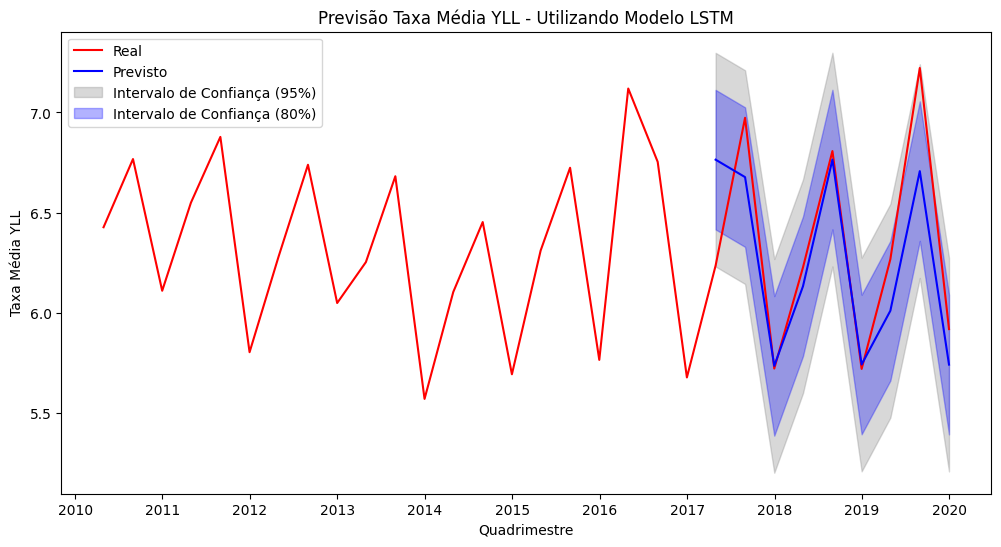

MAE: 0.21595498919487
MSE: 0.08209207653999329
RMSE: 0.2865171432495117
MAPE: 0.03296265751123428
TU: 0.2491769641637802
Durbin-Watson: 1.4204516410827637


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Dados
train_data = time_series.values

# Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0, 1))
train_data = normalizer.fit_transform(train_data)

# Cria os Arrays No Formato Certo
window_size = 3
x = []
y = []
for i in range(window_size, len(train_data)):
    x.append(train_data[i - window_size:i, 0])
    y.append(train_data[i, 0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')

# Divide os dados em treinamento e teste (70% treino, 30% teste)
split_index = int(len(x) * 0.7)
x_train, y_train = x[:split_index], y[:split_index]
x_test, y_test = x[split_index:], y[split_index:]

# Cria o Modelo De Rede Neural
dropout_val = 0.2
regressor = Sequential()
regressor.add(LSTM(units=800, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=300, return_sequences=True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=200))
regressor.add(Dropout(dropout_val))

regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Callback para Early Stopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=100,
    restore_best_weights=True
)

# Treinando o melhor modelo com o conjunto de treinamento com Early Stopping
history = regressor.fit(
    x_train, y_train,
    batch_size=16,
    epochs=1000,
    callbacks=[early_stopping]
)

# Fazendo as previsões
y_test = y_test.reshape(-1, 1)
train_predictions = regressor.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

# Criação do DataFrame de Resultados
train_results = pd.DataFrame(zip(train_predictions, y_test), columns=['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])

# Gerar índice para os dados de teste (frequência quadrimestral)
start_date = "2017-04-30"
test_index = pd.date_range(start=start_date, periods=len(y_test), freq='4M')

# Plotar os resultados com intervalos de confiança
plt.figure(figsize=(12, 6))

# Dados reais completos
plt.plot(time_series.index, time_series['taxa_media_yll'], color='red', label='Real', marker='')

# Previsões
plt.plot(test_index, train_predictions.flatten(), color='blue', label='Previsto', marker='')

# Calcular o erro residual (diferença entre valores reais e previstos)
residuals = y_test - train_predictions
std_error = np.std(residuals)

# Definir os intervalos de confiança (95% e 80%)
confidence_interval_95 = 1.96 * std_error
confidence_interval_80 = 1.28 * std_error

# Intervalo de confiança (95%)
upper_bound_95 = train_predictions.flatten() + confidence_interval_95
lower_bound_95 = train_predictions.flatten() - confidence_interval_95

# Intervalo de confiança (80%)
upper_bound_80 = train_predictions.flatten() + confidence_interval_80
lower_bound_80 = train_predictions.flatten() - confidence_interval_80

# Plotar intervalo de confiança (95%)
plt.fill_between(test_index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')

# Plotar intervalo de confiança (80%)
plt.fill_between(test_index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

# Labels e título
plt.title('Previsão Taxa Média YLL - Utilizando Modelo LSTM')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Quadrimestre')
plt.legend()
plt.show()

# MÉTRICAS DE ERROS

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(train_results['valor_real'], train_results['previsao'])
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(train_results['valor_real'], train_results['previsao'])
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(train_results['valor_real'], train_results['previsao'])
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(train_results['valor_real'], train_results['previsao'])
print(f'TU: {tu}')

# Teste de Durbin-Watson
residuals = train_results['valor_real'] - train_results['previsao']
dw = durbin_watson(residuals)
print(f'Durbin-Watson: {dw}')


### Modelo LSTM - Martina - Fine Tuning

Trial 1 Complete [00h 00m 17s]
val_mean_squared_error: 0.03014097362756729

Best val_mean_squared_error So Far: 0.03014097362756729
Total elapsed time: 00h 00m 17s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 800)         │     2,566,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 300)         │     1,321,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 100)         │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,001 (16.36 MB)

 Trainable params: 4,289,001 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0864 - val_mean_squared_error: 0.0864
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0648 - val_mean_squared_error: 0.0648
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0534 - val_mean_squared_error: 0.0534
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0417 - v

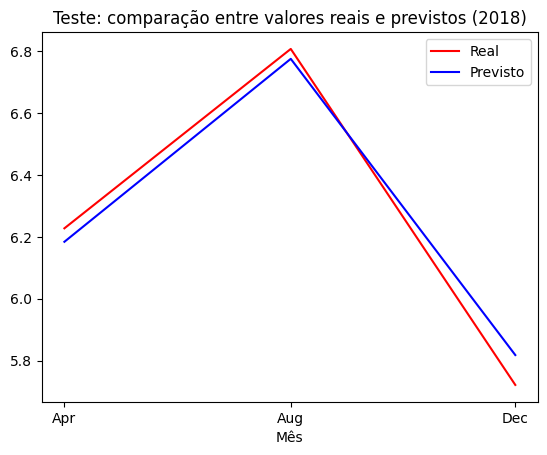

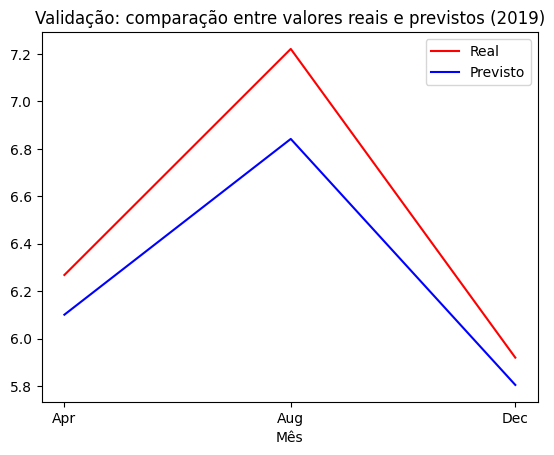

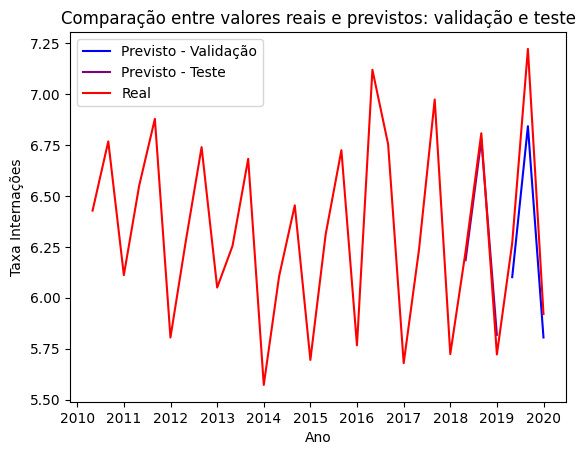

MAE: 0.05738496780395508
MSE: 0.004083293955773115
RMSE: 0.0639006569981575
MAPE: 0.009525884874165058
TU: 0.06213449686765671
Durbin-Watson: 1.361289620399475


In [4]:
import pandas as pd
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import shutil

train_data= time_series.values

# Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0,1))
train_data = normalizer.fit_transform(train_data)

# Cria os Arrays No Formato Certo
window_size = 3
x = []
y = []
for i in range(window_size, len(train_data)):
    x.append(train_data[i - window_size:i, 0])
    y.append(train_data[i, 0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')

# Divide os dados em treinamento e teste (80% treino, 10% teste, 10% validação)
split_index_1 = int(len(x) * 0.8)
split_index_2 = int(len(x) * 0.9)
x_train, y_train = x[:split_index_1], y[:split_index_1]
x_test, y_test = x[split_index_1:split_index_2], y[split_index_1:split_index_2]
x_val, y_val = x[split_index_2:], y[split_index_2:]

dropout_val = 0.2

def build_model(hp):
    neurons_first_layer = hp.Choice('neurons_first_layer', [800])
    neurons_second_layer = hp.Choice('neurons_second_layer', [300])
    neurons_third_layer = hp.Choice('neurons_third_layer', [100])
    neurons_fourth_layer = hp.Choice('neurons_fourth_layer', [200])
    dropout_val = hp.Choice('dropout_val', [0.2])

    regressor = Sequential()
    regressor.add(LSTM(units=neurons_first_layer, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    regressor.add(Dropout(dropout_val))

    if neurons_second_layer:
        regressor.add(LSTM(units=neurons_second_layer, return_sequences=True))
        regressor.add(Dropout(dropout_val))

    if neurons_third_layer:
        regressor.add(LSTM(units=neurons_third_layer, return_sequences=True))
        regressor.add(Dropout(dropout_val))

    if neurons_fourth_layer:
        regressor.add(LSTM(units=neurons_fourth_layer))
        regressor.add(Dropout(dropout_val))

    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return regressor

# Configurando o tuner para realizar uma busca em grade
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    directory="my_dir",
    project_name="otimizacao_keras_tuner"
)

tuner.search(x_train, y_train, batch_size = 16, epochs=100, validation_data=(x_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# # Treinando o melhor modelo com o conjunto de treinamento
# history = best_model.fit(x_train, y_train, batch_size = 16, epochs=100, validation_data=(x_val, y_val))

# Callback para Early Stopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=100,
    restore_best_weights=True
)

# Treinando o melhor modelo com o conjunto de treinamento com Early Stopping
history = best_model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

y_test = y_test.reshape(-1, 1)
train_predictions = best_model.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

y_val = y_val.reshape(-1, 1)
val_predictions = best_model.predict(x_val)
val_predictions = normalizer.inverse_transform(val_predictions)
y_val = normalizer.inverse_transform(y_val)

# Remove the directory containing the previous tuning results
try:
    shutil.rmtree('my_dir')
except:
    print('Diretório não encontrado.')

train_results = pd.DataFrame(zip(train_predictions, y_test), columns = ['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])

train_results_val = pd.DataFrame(zip(val_predictions, y_val), columns = ['previsao', 'valor_real'])
train_results_val['previsao'] = train_results_val['previsao'].apply(lambda x: x[0])
train_results_val['valor_real'] = train_results_val['valor_real'].apply(lambda x: x[0])

start_date = "2018-04-30"
train_results['data'] = pd.date_range(start=start_date, periods=len(train_results), freq='4M')
train_results.set_index('data', inplace=True)

train_results

start_date = "2019-04-30"
train_results_val['data'] = pd.date_range(start=start_date, periods=len(train_results_val), freq='4M')
train_results_val.set_index('data', inplace=True)

train_results_val

plt.plot(train_results['valor_real'], color='red', label = 'Real')
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
# Formatando o eixo x para mostrar apenas o mês
plt.xticks(ticks=train_results.index, labels=train_results.index.strftime('%b'))

plt.title('Teste: comparação entre valores reais e previstos (2018)')
plt.xlabel('Mês')
plt.legend()
plt.show()

plt.plot(train_results_val['valor_real'], color='red', label = 'Real')
plt.plot(train_results_val['previsao'], color='blue', label = 'Previsto')
# Formatando o eixo x para mostrar apenas o mês
plt.xticks(ticks=train_results_val.index, labels=train_results_val.index.strftime('%b'))
# Adicionando um título ao gráfico
plt.title('Validação: comparação entre valores reais e previstos (2019)')
plt.xlabel('Mês')
plt.legend()
plt.show()

plt.plot(train_results_val['previsao'], color='blue', label = 'Previsto - Validação')
plt.plot(train_results['previsao'], color='purple', label = 'Previsto - Teste')
plt.plot(time_series, color='red', label = 'Real')

plt.title('Comparação entre valores reais e previstos: validação e teste')
plt.ylabel('Taxa Internações')
plt.xlabel('Ano')
plt.legend()
plt.show()

# MÉTRICAS DE ERROS

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(train_results['valor_real'], train_results['previsao'])
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(train_results['valor_real'], train_results['previsao'])
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(train_results['valor_real'], train_results['previsao'])
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(train_results['valor_real'], train_results['previsao'])
print(f'TU: {tu}')

# Teste de Durbin-Watson
residuals = train_results['valor_real'] - train_results['previsao']
dw = durbin_watson(residuals)
print(f'Durbin-Watson: {dw}')

### Modelo LSTM - 3

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.2196 - val_loss: 0.1536
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0992 - val_loss: 0.1019
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0777 - val_loss: 0.1259
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1122 - val_loss: 0.1049
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1044 - val_loss: 0.1017
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0773 - val_loss: 0.1112
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0906 - val_loss: 0.1179
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0843 - val_loss: 0.1158
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0856 - val_loss: 0.1020
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0685 - val_loss: 0.0917
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0721 - val_loss: 0.0879
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0646 - val_lo

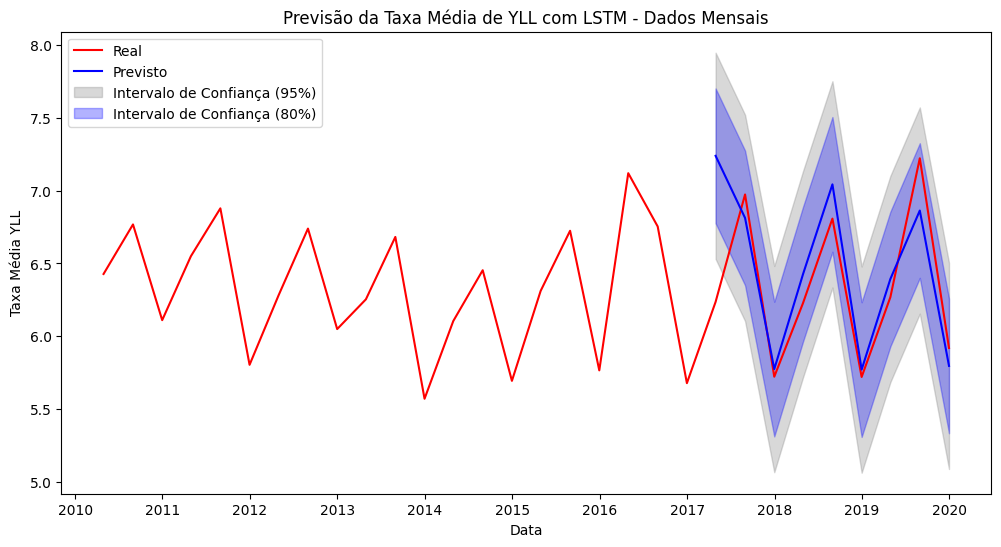

MAE: 0.2560651064680271
MSE: 0.14307251486802794
RMSE: 0.37824927609716313
MAPE: 0.039807924298610985
TU: 0.2993676310994603
Durbin-Watson: 1.357784688882969


In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

# Carregar os dados e definir o índice de data
time_series_data = time_series['taxa_media_yll'].values

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# 2. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# 3. Preparar os dados para a LSTM
def create_sequences(data, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir o tamanho da sequência de entrada
sequence_length = 3
X, y = create_sequences(time_series_data, sequence_length)

# 4. Dividir os dados em treino e teste
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Construir o modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# 6. Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 7. Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 8. Fazer previsões
predicted = model.predict(X_test)

# 9. Desnormalizar os dados para interpretação
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# 11. Plotar os resultados com intervalos de confiança
plt.figure(figsize=(12, 6))

# Dados reais completos
plt.plot(time_series.index, time_series['taxa_media_yll'], color='red', label='Real', marker='')

# Previsões
test_index = time_series.index[-len(y_test):]
plt.plot(test_index, predicted.flatten(), color='blue', label='Previsto', marker='')

# Calcular o erro residual (diferença entre valores reais e previstos)
residuals = y_test - predicted
std_error = np.std(residuals)

# Definir os intervalos de confiança (95% e 80%)
confidence_interval_95 = 1.96 * std_error
confidence_interval_80 = 1.28 * std_error

# Intervalo de confiança (95%)
upper_bound_95 = predicted.flatten() + confidence_interval_95
lower_bound_95 = predicted.flatten() - confidence_interval_95

# Intervalo de confiança (80%)
upper_bound_80 = predicted.flatten() + confidence_interval_80
lower_bound_80 = predicted.flatten() - confidence_interval_80

# Plotar intervalo de confiança (95%)
plt.fill_between(test_index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')

# Plotar intervalo de confiança (80%)
plt.fill_between(test_index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

# Labels e título
plt.title('Previsão da Taxa Média de YLL com LSTM - Dados Mensais')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.legend()
plt.show()

# 12. Calcular as métricas de erro

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(y_test, predicted)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(y_test, predicted)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(y_test, predicted)
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(y_test, predicted)
print(f'TU: {tu}')

# Teste de Durbin-Watson
residuals = y_test.flatten() - predicted.flatten()
dw = durbin_watson(residuals)
print(f'Durbin-Watson: {dw}')

### Modelo LSTM - 4

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.2306 - val_loss: 0.2963
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2480 - val_loss: 0.2789
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2258 - val_loss: 0.2607
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2436 - val_loss: 0.2404
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1981 - val_loss: 0.2167
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1579 - val_loss: 0.1904
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1730 - val_loss: 0.1632
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1388 - val_loss: 0.1375
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1109 - val_loss: 0.1137
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0909 - val_loss: 0.0960
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0632 - val_loss: 0.0844
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0693 - val_l

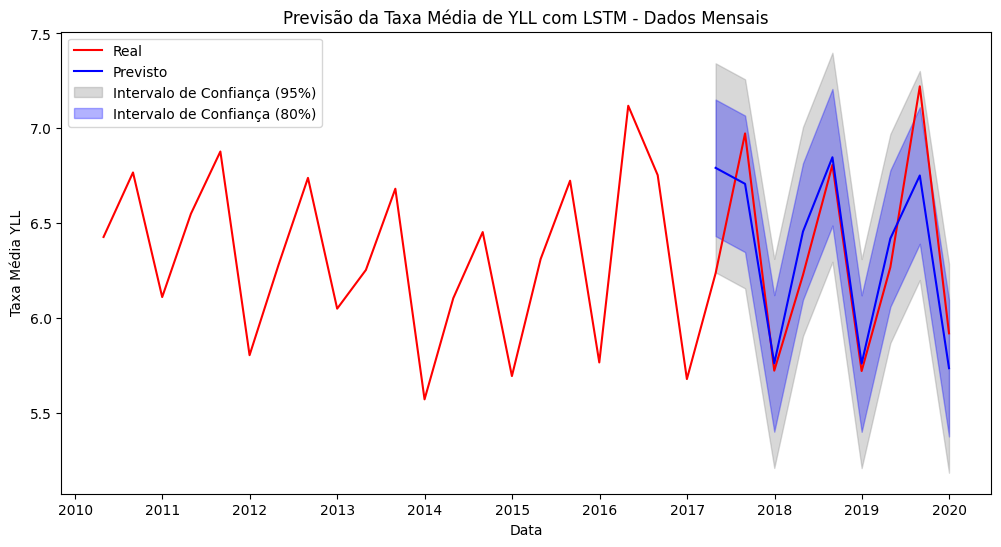

MAE: 0.21909359038865428
MSE: 0.07922005497199171
RMSE: 0.2814605744540285
MAPE: 0.033719984316280475
TU: 0.24087896229348807
Durbin-Watson: 1.8480652004756999


In [6]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

# Carregar os dados e definir o índice de data
time_series_data = time_series['taxa_media_yll'].values

import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 3. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# 4. Preparar os dados para a LSTM
def create_sequences(data, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 3
X, y = create_sequences(time_series_data, sequence_length)

# 5. Dividir os dados em treino e teste (70/30)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 6. Construir o modelo LSTM
model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2), # Adicionar dropout para regularização
    LSTM(50, activation='relu'),
    Dense(1)
])

# 7. Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 8. Treinar o modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 9. Fazer previsões
predicted = model.predict(X_test)

# 10. Desnormalizar as previsões e valores reais para comparação
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# 11. Plotar os resultados com intervalos de confiança
plt.figure(figsize=(12, 6))

# Dados reais completos
plt.plot(time_series.index, time_series['taxa_media_yll'], color='red', label='Real', marker='')

# Previsões
test_index = time_series.index[-len(y_test):]
plt.plot(test_index, predicted.flatten(), color='blue', label='Previsto', marker='')

# Calcular o erro residual (diferença entre valores reais e previstos)
residuals = y_test - predicted
std_error = np.std(residuals)

# Definir os intervalos de confiança (95% e 80%)
confidence_interval_95 = 1.96 * std_error
confidence_interval_80 = 1.28 * std_error

# Intervalo de confiança (95%)
upper_bound_95 = predicted.flatten() + confidence_interval_95
lower_bound_95 = predicted.flatten() - confidence_interval_95

# Intervalo de confiança (80%)
upper_bound_80 = predicted.flatten() + confidence_interval_80
lower_bound_80 = predicted.flatten() - confidence_interval_80

# Plotar intervalo de confiança (95%)
plt.fill_between(test_index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')

# Plotar intervalo de confiança (80%)
plt.fill_between(test_index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

# Labels e título
plt.title('Previsão da Taxa Média de YLL com LSTM - Dados Mensais')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.legend()
plt.show()

# 12. Calcular as métricas de erro

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(y_test, predicted)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(y_test, predicted)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(y_test, predicted)
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(y_test, predicted)
print(f'TU: {tu}')

# Teste de Durbin-Watson
residuals = y_test.flatten() - predicted.flatten()
dw = durbin_watson(residuals)
print(f'Durbin-Watson: {dw}')